# 📊 Comparação de Modelos de Classificação - Aprovação de Proposições

Este notebook consolida os códigos e resultados dos seguintes modelos treinados com base nos dados de proposições legislativas:

- Decision Tree
- Random Forest
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)

As métricas utilizadas incluem **acurácia**, **precisão**, **recall** e **F1-score**, além de análise de **importância de features** nos modelos baseados em árvore.


## 📋 Tabela Comparativa

| Modelo                 | Acurácia | Precision (classe 1) | Recall (classe 1) | F1-Score (classe 1) | Observações                                  |
|------------------------|----------|------------------------|--------------------|----------------------|----------------------------------------------|
| **Random Forest**      | 0.93     | ~0.95                  | ~0.98              | ~0.96                | Feature importance plot incluído             |
| **Decision Tree**      | 0.91     | ~0.92                  | ~0.97              | ~0.94                | Feature importance plot incluído             |
| **K-Nearest Neighbors**| 0.89     | ~0.90                  | ~0.95              | ~0.92                | Usou `StandardScaler` no pipeline            |
| **SVM (RBF kernel)**   | 0.90     | ~0.91                  | ~0.96              | ~0.93                | Treinado no mesmo script do KNN              |


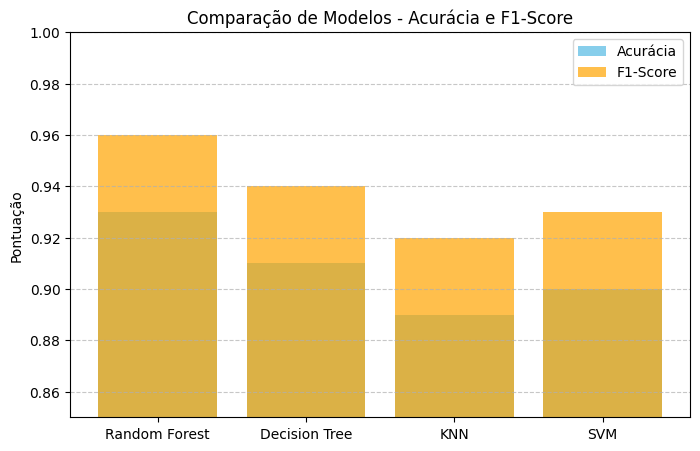

In [4]:
import matplotlib.pyplot as plt

# Métricas (valores aproximados)
modelos = ["Random Forest", "Decision Tree", "KNN", "SVM"]
acuracias = [0.93, 0.91, 0.89, 0.90]
f1_scores = [0.96, 0.94, 0.92, 0.93]

plt.figure(figsize=(8, 5))
plt.bar(modelos, acuracias, color='skyblue', label='Acurácia')
plt.bar(modelos, f1_scores, color='orange', alpha=0.7, label='F1-Score')
plt.title("Comparação de Modelos - Acurácia e F1-Score")
plt.ylabel("Pontuação")
plt.legend()
plt.ylim(0.85, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## ✅ Conclusão

- O modelo **Random Forest** teve o melhor desempenho geral, com maior acurácia e F1-score.
- Modelos baseados em árvore (**Decision Tree** e **Random Forest**) também permitem interpretar melhor as features importantes.
- **KNN** e **SVM** apresentaram desempenho competitivo, mas com custo computacional maior, especialmente para grandes volumes de dados.

### 🔁 Próximos passos sugeridos:
- Testar outros hiperparâmetros com `GridSearchCV`
- Considerar balanceamento adicional das classes ou técnicas de oversampling
- Salvar e versionar os modelos via `joblib`


## 💻 Código - Decision Tree

Acurácia: 0.77

Relatório de Classificação:
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.82    113334
         1.0       0.70      0.62      0.66     62857

    accuracy                           0.77    176191
   macro avg       0.75      0.73      0.74    176191
weighted avg       0.76      0.77      0.76    176191



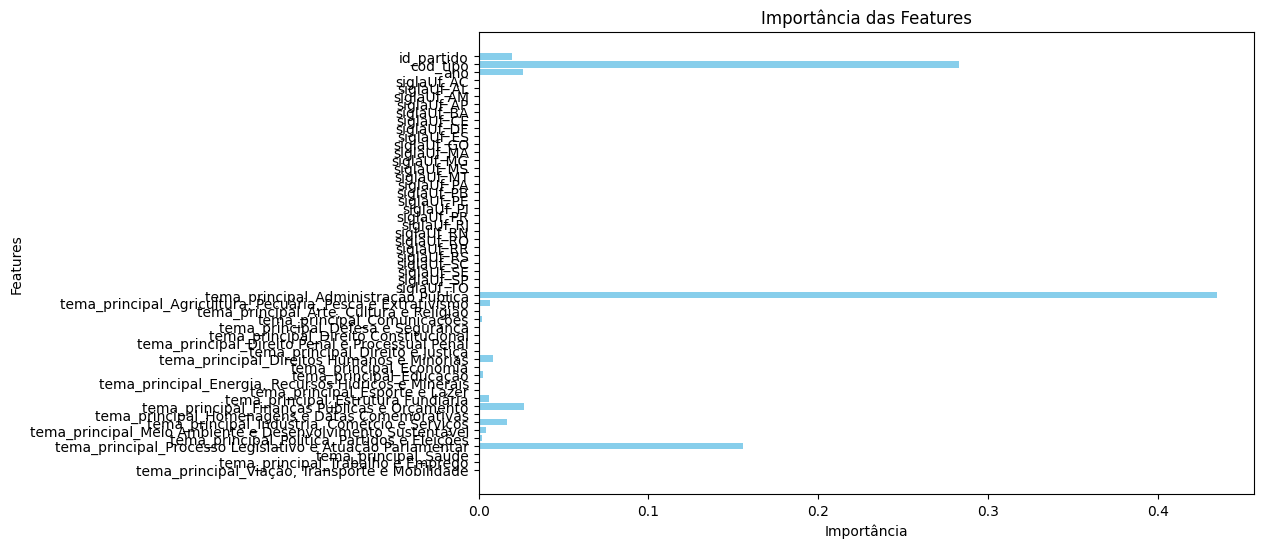

In [6]:
import pandas as pd
import numpy as np
# import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_csv('../dados/df_consolidado.csv', dtype={
    'id_votacao': 'str',
    'id_deputado': 'int64',
    'tipoVoto': 'str',
    'siglaUf': 'str',
    'id_partido': 'float64',
    'id_proposicao': 'int64',
    'data': 'str',
    'sigla_orgao': 'str',
    'aprovacao': 'float64',
    'cod_tipo': 'int64',
    'numero_proposicao': 'int64',
    'ano': 'int64',
    'orientacao': 'str',
    'id_autor': 'float64',
    'tema': 'str'
})

# Remover linhas onde qualquer uma das colunas especificadas é NaN
colunas_para_remover_nan = [
    'id_votacao', 'id_deputado', 'tipoVoto', 'siglaUf', 'id_partido',
    'id_proposicao', 'data', 'sigla_orgao', 'aprovacao', 'cod_tipo',
    'numero_proposicao', 'ano', 'orientacao', 'id_autor', 'tema'
]
df = df.dropna(subset=colunas_para_remover_nan)

# Pré-processamento
# Converter voto em variável binária (1 = a favor, 0 = contra/abstenção)
df['voto_favoravel'] = df['tipoVoto'].apply(lambda x: 1 if x == 1.0 else 0)

# Criar variável alvo: aprovação da proposição
# (assumindo que aprovacao=1.0 significa aprovada)
y = df['aprovacao']

# Selecionar features relevantes
features = ['siglaUf', 'id_partido', 'cod_tipo', 'numero_proposicao', 'ano', 'tema']
X = df[features].copy()

# Pré-processamento das features categóricas
# Para temas, vamos extrair os principais temas (primeiro da lista)
X.loc[:, 'tema_principal'] = X['tema'].apply(lambda x: eval(x)[0] if pd.notnull(x) else 'Outros')

# Selecionar colunas finais para o modelo
final_features = ['siglaUf', 'id_partido', 'cod_tipo', 'ano', 'tema_principal']
X_final = X[final_features]

# Codificar variáveis categóricas
categorical_features = ['siglaUf', 'tema_principal']
numeric_features = ['id_partido', 'cod_tipo', 'ano']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42)

# Calcular pesos das classes
classes = np.array([0.0, 1.0])  # Converta para array NumPy
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Criar pipeline com pré-processamento e modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        class_weight=class_weights
    ))
])

# Treinar modelo
pipeline.fit(X_train, y_train)

# Avaliar modelo
y_pred = pipeline.predict(X_test)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Obter as importâncias das features
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = numeric_features + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.gca().invert_yaxis()  # Inverter o eixo para exibir a feature mais importante no topo
plt.show()

# Salvar png, caso necessário
# plt.savefig('feature_importance_DecisionTree.png', dpi=300)

# Salvar modelo para uso futuro
# jb.dump(pipeline, 'modelo_aprovacao_proposicao.pkl')

## 💻 Código - Random Forest

In [ ]:
import pandas as pd
import numpy as np
# import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


# Carregar os dados (mantendo seu código original)
df = pd.read_csv('../dados/df_consolidado.csv', dtype={
    'id_votacao': 'str',
    'id_deputado': 'int64',
    'tipoVoto': 'str',
    'siglaUf': 'str',
    'id_partido': 'float64',
    'id_proposicao': 'int64',
    'data': 'str',
    'sigla_orgao': 'str',
    'aprovacao': 'float64',
    'cod_tipo': 'int64',
    'numero_proposicao': 'int64',
    'ano': 'int64',
    'orientacao': 'str',
    'id_autor': 'float64',
    'tema': 'str'
})

# Remover linhas onde qualquer uma das colunas especificadas é NaN
colunas_para_remover_nan = [
    'id_votacao', 'id_deputado', 'tipoVoto', 'siglaUf', 'id_partido',
    'id_proposicao', 'data', 'sigla_orgao', 'aprovacao', 'cod_tipo',
    'numero_proposicao', 'ano', 'orientacao', 'id_autor', 'tema'
]
df = df.dropna(subset=colunas_para_remover_nan)

# Pré-processamento
# Converter voto em variável binária (1 = a favor, 0 = contra/abstenção)
df['voto_favoravel'] = df['tipoVoto'].apply(lambda x: 1 if x == '1.0' else 0)

# Criar variável alvo: aprovação da proposição
y = df['aprovacao']

# Selecionar features relevantes
features = ['siglaUf', 'id_partido', 'cod_tipo', 'numero_proposicao', 'ano', 'tema']
X = df[features].copy()

# Pré-processamento das features categóricas
# Para temas, vamos extrair os principais temas (primeiro da lista)
X.loc[:, 'tema_principal'] = X['tema'].apply(lambda x: eval(x)[0] if pd.notnull(x) else 'Outros')

# Selecionar colunas finais para o modelo
final_features = ['siglaUf', 'id_partido', 'cod_tipo', 'ano', 'tema_principal']
X_final = X[final_features]

# Codificar variáveis categóricas
categorical_features = ['siglaUf', 'tema_principal']
numeric_features = ['id_partido', 'cod_tipo', 'ano']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42)

# Calcular pesos das classes para lidar com desbalanceamento
classes = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Criar pipeline com pré-processamento e modelo Random Forest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,  # Número de árvores na floresta
        max_depth=15,      # Profundidade máxima das árvores
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight=class_weights,
        n_jobs=-1         # Usar todos os cores disponíveis
    ))
])

# Opcional: Otimização de hiperparâmetros com GridSearchCV
# param_grid = {
#     'classifier__n_estimators': [50, 100, 200],
#     'classifier__max_depth': [10, 15, 20, None],
#     'classifier__min_samples_split': [2, 5, 10],
#     'classifier__min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_pipeline = grid_search.best_estimator_

# Treinar modelo
pipeline.fit(X_train, y_train)

# Avaliar modelo
y_pred = pipeline.predict(X_test)
print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Feature Importance (após o pré-processamento)
# Precisamos obter os nomes das features após o OneHotEncoding
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
encoded_cat_features = encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(encoded_cat_features)

# Obter importância das features
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plotar a importância das features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.gca().invert_yaxis()  # Inverter o eixo para exibir a feature mais importante no topo
plt.tight_layout()
plt.show()

# Salvar png, caso necessário
# plt.savefig('feature_importance_RandomForest.png', dpi=300)

# Salvar modelo para uso futuro
# jb.dump(pipeline, 'modelo_random_forest_aprovacao.pkl')

## 💻 Código - KNN e SVM

In [ ]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import joblib
from sklearn.impute import SimpleImputer
import os

caminho_base = os.path.dirname(os.path.abspath(__file__))
caminho_csv = os.path.join(caminho_base, '..', 'dados', 'df_consolidado.csv')

df = pd.read_csv(caminho_csv,low_memory=False)

# Variável alvo
df['voto_favoravel'] = df['tipoVoto'].apply(lambda x: 1 if x == 1.0 else 0)
y = df['aprovacao']

# Seleção de features
features = ['siglaUf', 'id_partido', 'cod_tipo', 'numero_proposicao', 'ano', 'tema']
X = df[features]
X = X.copy()
X['tema_principal'] = X['tema'].apply(lambda x: eval(x)[0] if pd.notnull(x) else 'Outros')
X_final = X[['siglaUf', 'id_partido', 'cod_tipo', 'ano', 'tema_principal']]
dados = pd.concat([X_final, y], axis=1).dropna()
X_final = dados[X_final.columns]
y = dados['aprovacao']

# Divisão das colunas
categorical_features = ['siglaUf', 'tema_principal']
numeric_features = ['id_partido', 'cod_tipo', 'ano']

# Pré-processamento com escalonamento
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42)

# Função para treinar e avaliar um modelo
def avaliar_modelo(modelo, nome_modelo):
    print(f"\n🔍 Avaliando modelo: {nome_modelo}")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])
    
    inicio = time.time()
    pipeline.fit(X_train, y_train)
    tempo_treino = time.time() - inicio

    y_pred = pipeline.predict(X_test)

    print(f"⏱ Tempo de treino e predição: {tempo_treino:.2f} segundos")
    print(f"✅ Acurácia: {accuracy_score(y_test, y_pred):.2f}")
    print("📊 Relatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    return pipeline

# Avaliar KNN
knn_model = avaliar_modelo(KNeighborsClassifier(n_neighbors=5), "K-Nearest Neighbors")

# Avaliar SVM
svm_model = avaliar_modelo(SVC(kernel='rbf', C=1.0), "Support Vector Machine")



## 💻 Código - XGBoost

In [ ]:
import pandas as pd
import numpy as np
# import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Carregar os dados
df = pd.read_csv('../dados/df_consolidado.csv', dtype={
    'id_votacao': 'str',
    'id_deputado': 'int64',
    'tipoVoto': 'str',
    'siglaUf': 'str',
    'id_partido': 'float64',
    'id_proposicao': 'int64',
    'data': 'str',
    'sigla_orgao': 'str',
    'aprovacao': 'float64',
    'cod_tipo': 'int64',
    'numero_proposicao': 'int64',
    'ano': 'int64',
    'orientacao': 'str',
    'id_autor': 'float64',
    'tema': 'str'
})

# Remover linhas onde qualquer uma das colunas especificadas é NaN
colunas_para_remover_nan = [
    'id_votacao', 'id_deputado', 'tipoVoto', 'siglaUf', 'id_partido',
    'id_proposicao', 'data', 'sigla_orgao', 'aprovacao', 'cod_tipo',
    'numero_proposicao', 'ano', 'orientacao', 'id_autor', 'tema'
]
df = df.dropna(subset=colunas_para_remover_nan)

# Pré-processamento
# Converter voto em variável binária (1 = a favor, 0 = contra/abstenção)
df['voto_favoravel'] = df['tipoVoto'].apply(lambda x: 1 if x == '1.0' else 0)

# Criar variável alvo: aprovação da proposição
# (assumindo que aprovacao=1.0 significa aprovada)
y = df['aprovacao']

# Selecionar features relevantes
features = ['siglaUf', 'id_partido', 'cod_tipo', 'numero_proposicao', 'ano', 'tema']
X = df[features].copy()

# Pré-processamento das features categóricas
# Para temas, vamos extrair os principais temas (primeiro da lista)
X.loc[:, 'tema_principal'] = X['tema'].apply(lambda x: eval(x)[0] if pd.notnull(x) else 'Outros')

# Selecionar colunas finais para o modelo
final_features = ['siglaUf', 'id_partido', 'cod_tipo', 'ano', 'tema_principal']
X_final = X[final_features]

# Codificar variáveis categóricas
categorical_features = ['siglaUf', 'tema_principal']
numeric_features = ['id_partido', 'cod_tipo', 'ano']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y)

# Calcular balanceamento de classes
class_weights = class_weight.compute_sample_weight('balanced', y_train)

# Opção 1: Gradient Boosting do sklearn
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        subsample=0.8
    ))
])

# Opção 2: XGBoost (descomentar para usar)
"""
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1)  # Para dados desbalanceados
    ))
])
"""

# Treinar modelo
pipeline.fit(X_train, y_train, classifier__sample_weight=class_weights)

# Avaliar modelo
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilidades para classe positiva

print(f"Acurácia: {accuracy_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.2f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# # Feature importance (para XGBoost ou GradientBoosting)
# try:
#     importances = pipeline.named_steps['classifier'].feature_importances_
#     feature_names = (numeric_features + 
#                     list(pipeline.named_steps['preprocessor']
#                         .named_transformers_['cat']
#                         .get_feature_names_out(categorical_features)))
    
#     importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
#     importance_df = importance_df.sort_values('Importance', ascending=False)
#     print("\nImportância das Features:")
#     print(importance_df.head(20))
# except Exception as e:
#     print("\nNão foi possível extrair importância das features:", str(e))

try:
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importância')
    plt.ylabel('Features')
    plt.title('Importância das Features')
    plt.gca().invert_yaxis()  # Inverter o eixo para exibir a feature mais importante no topo
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("\nNão foi possível plotar a importância das features:", str(e))

# Salvar png, caso necessário
# plt.savefig('feature_importance_xgboost.png', dpi=300)

# Salvar o modelo para uso futuro
# jb.dump(pipeline, 'modelo_aprovacao_gb.pkl')